In [1]:
import random
import numpy as np

from deap import base
from deap import creator
from deap import tools

import matplotlib.pyplot as plt
plt.style.use("seaborn")

%matplotlib inline

In [2]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Setup the System
- genome is now 3 params: distance OH1, Distance Oh2, angle H1OH2.
- Molecule will always be in xy plane


In [16]:
toolbox = base.Toolbox()

def init_individual():
    return [random.gauss(1, 0.4), random.gauss(1, 0.4), random.gauss(2, 0.4)]


toolbox.register("init_individual", tools.initIterate, 
                 creator.Individual, init_individual)

toolbox.register("init_population", tools.initRepeat, 
                 list, toolbox.init_individual)

In [4]:
from pyscf.gto import Mole
from pyscf.scf import RHF

def build_molecule_from_genome(genome):
    
    atoms = [
        ("O", 0, 0, 0),
        ("H", genome[0], 0, 0),
        ("H", genome[1] * np.cos(genome[2]), genome[1] * np.sin(genome[2]), 0)
    ]
    
    mol = Mole()
    mol.atom = atoms
    mol.basis = "6-31++g**"
    #mol.basis = "sto-3g"
    mol.build()
    return mol
    
def evaluateFitness(individual):
    
    mol = build_molecule_from_genome(individual)
    
    mf = RHF(mol)
    mf.verbose = 0
    E = mf.scf()
    
    # this shit has to be a tuple!!
    return E,

toolbox.register("evaluate", evaluateFitness)

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.05) # flip gene with 0.05 % probability
toolbox.register("select", tools.selTournament, tournsize=3)

# Do the Optimazation 

In [6]:
PROBABILITY_CROSSING = 0.5
PROBABILITY_MUTATION = 0.2

MAX_ITERATIONS = 100

CONVERGENCE_THRESHOLD = 1e-7

E_old = 1e10

In [17]:
SIZE_POPULATION = 100

population = toolbox.init_population(n=SIZE_POPULATION)

In [18]:
population

[[0.8137656244740837, 0.7987857548604269, 2.253935179078141],
 [1.4903600920347897, 2.475895546236888, 2.429394282640564],
 [1.247962236573958, 1.532670427264381, 2.09603921723665],
 [0.8832635792179389, 0.44152657668938133, 2.3718087605792286],
 [1.0311260451378153, 1.018800390170588, 2.988713063319838],
 [1.4554586071345446, 1.1922874770354746, 1.6320294500707888],
 [0.5636028602377574, 0.7729292200451316, 1.560301970529234],
 [0.9137555720095747, 0.9003625447175544, 2.0356135519647163],
 [0.5352413125478677, 1.0185296161948112, 2.268518587539612],
 [1.1175968691653781, 1.2927533996400333, 2.1723441173822904],
 [1.4019138635351056, 1.6484375081977358, 2.4605336368278605],
 [1.3138506039486375, 1.529937406114088, 2.0404909353030454],
 [0.3738237430826543, 1.1836354473903699, 1.9892425767137107],
 [0.9414482438074699, 0.29462238438363997, 2.1106454458717616],
 [1.4812921019252479, 1.3988980783783114, 2.202609984612041],
 [0.19282476423029027, 0.8545040468420657, 1.1969531594317153],
 [

In [9]:
fitnesses = list(map(toolbox.evaluate, population))

for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

In [10]:
best_ind = tools.selBest(population, 1)[0]
print("Pre:")
print(best_ind, best_ind.fitness.values)

Pre:
[0.9339022619606353, 0.9964442094730125, 1.7611900590172258] (-76.0273038603613,)


In [11]:
# create a list of fitness values
fitness_values = [ind.fitness.values[0] for ind in population]

# Begin the evolution
for i in range(MAX_ITERATIONS):

    # Select next generation
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # do cross over
    for child1, child2 in zip(offspring[::2], offspring[1::2]):

        if random.random() < PROBABILITY_CROSSING:
            toolbox.mate(child1, child2)

            del child1.fitness.values
            del child2.fitness.values
            
    # do mutation
    for mutant in offspring:
        if random.random() < PROBABILITY_MUTATION:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    
    # recalculate fitness values of mates and mutants
    invalid_individuals = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_individuals)
    for ind, fit in zip(invalid_individuals, fitnesses):
        ind.fitness.values = fit
    
    population[:] = offspring
    
    # update list of fitness value
    fitness_values = [ind.fitness.values[0] for ind in population]
    
    #E = sum(fitness_values) / len(fitness_values)
    E = sum(fitness_values) / float(SIZE_POPULATION)
    print("Generation: " + str(i+1))
    print(E, np.abs(E_old-E))
    
    
    if np.abs(E - E_old) < CONVERGENCE_THRESHOLD:
        print("\n\nCONVERGED!\n")
        break

    else:
        E_old = E
        
    

Generation: 1
-75.91694380294112 10000000075.916945
Generation: 2
-75.98820876218764 0.07126495924651977
Generation: 3
-76.00853999043319 0.02033122824555278
Generation: 4
-76.01940984131065 0.010869850877455178
Generation: 5
-76.02672840582483 0.007318564514179116
Generation: 6
-76.02670917816003 1.9227664793675103e-05
Generation: 7
-75.87173361351257 0.154975564647458
Generation: 8
-76.02709682731637 0.15536321380379547
Generation: 9
-76.02942086822269 0.002324040906316327
Generation: 10
-76.01853015010632 0.010890718116371545
Generation: 11
-75.72071029603264 0.29781985407367983
Generation: 12
-76.02092819009735 0.30021789406471555
Generation: 13
-76.00408121182807 0.016846978269285273
Generation: 14
-76.02930879968898 0.02522758786091117
Generation: 15
-76.01995517642298 0.009353623265994315
Generation: 16
-75.80955827736136 0.21039689906162096
Generation: 17
-75.82110732000821 0.011549042646848307
Generation: 18
-76.02783997153148 0.20673265152326792
Generation: 19
-76.00522087671

In [12]:
population

[[0.9419666610772246, 0.9495123046286492, 1.887405307152916],
 [0.9419666610772246, 0.9495123046286492, 1.887405307152916],
 [0.9419666610772246, 0.9495123046286492, 1.887405307152916],
 [0.9419666610772246, 1.8323958279510577, 1.887405307152916],
 [0.9419666610772246, 0.9495123046286492, 1.887405307152916],
 [0.9419666610772246, 0.9495123046286492, 1.887405307152916],
 [0.9419666610772246, 0.9495123046286492, 1.887405307152916],
 [0.9419666610772246, 0.9495123046286492, 1.887405307152916],
 [0.9419666610772246, 0.9495123046286492, 1.887405307152916],
 [0.9419666610772246, 0.9495123046286492, 1.887405307152916],
 [0.9419666610772246, 0.9495123046286492, 1.887405307152916],
 [0.9419666610772246, 0.9495123046286492, 1.887405307152916],
 [0.9419666610772246, 0.9495123046286492, 1.887405307152916],
 [0.9419666610772246, 0.9495123046286492, 1.887405307152916],
 [0.9419666610772246, 0.9495123046286492, 1.887405307152916],
 [0.9419666610772246, 0.9495123046286492, 1.887405307152916],
 [0.9419

# Checking the Result 

In [13]:
best_ind = tools.selBest(population, 1)[0]
print("Distances: \n - {0}\n - {1}".format(best_ind[0], best_ind[1]))
print("Angle: {0}".format(best_ind[2] * 360 / (2 * np.pi) % 360))
print("Energy: {0}".format(best_ind.fitness.values))

Distances: 
 - 0.9419666610772246
 - 0.9495123046286492
Angle: 108.14035833045489
Energy: (-76.03095319574619,)


In [14]:
mol = build_molecule_from_genome(best_ind)
mol.atom

[('O', 0, 0, 0),
 ('H', 0.9419666610772246, 0, 0),
 ('H', -0.29562674617908924, 0.902318371521257, 0)]

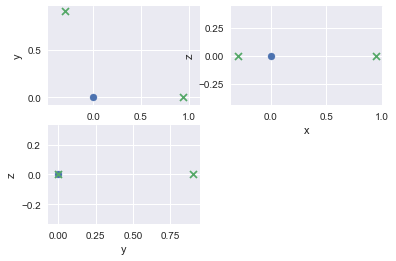

In [15]:
import matplotlib.pylab as plt

x = [t[1] for t in mol.atom]
y = [t[2] for t in mol.atom]
z = [t[3] for t in mol.atom]

lower, upper = -1.5, 1.5

plt.subplot(2, 2, 1)
plt.scatter(x[0], y[0], label="C")
plt.scatter(x[1:], y[1:], marker="x", label="H")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(lower, upper)
plt.ylim(lower, upper)
plt.axis("equal")

plt.subplot(2, 2, 2)
plt.scatter(x[0], z[0], label="C")
plt.scatter(x[1:], z[1:], marker="x", label="H")
plt.xlabel("x")
plt.ylabel("z")
plt.xlim(lower, upper)
plt.ylim(lower, upper)
plt.axis("equal")

plt.subplot(2, 2, 3)
plt.scatter(y[0], z[0], label="C")
plt.scatter(y[1:], z[1:], marker="x", label="H")
plt.xlabel("y")
plt.ylabel("z")
plt.xlim(lower, upper)
plt.ylim(lower, upper)
plt.axis("equal")

plt.show()